In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader    
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.utils as vutils

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
## load dataset and transform into tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu
device

device(type='cpu')

In [7]:
data_dir = "/content/drive/MyDrive/Crop Dataset/cotton_dataset"

from os import listdir

train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# train_imgs = os.listdir(train_dir + '/diseased cotton leaf')
# print(len(os.listdir(train_dir + '/diseased cotton leaf')))

In [8]:
listdir(train_dir)

['fresh cotton plant',
 'diseased cotton leaf',
 'fresh cotton leaf',
 'diseased cotton plant']

In [9]:
#Load dataset
from torchvision import datasets, transforms

train_data = torchvision.datasets.ImageFolder(
    root = train_dir,
    transform = torchvision.transforms.ToTensor()
)

valid_data = torchvision.datasets.ImageFolder(
    root = valid_dir,
    transform = torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.ImageFolder(
    root = test_dir,
    transform = torchvision.transforms.ToTensor()
)

In [10]:
len(train_data), len(valid_data),len(test_data)

(1951, 253, 106)

In [11]:
#Visualizing the data in tensor form

image, label = train_data[0]
image.shape, label

(torch.Size([3, 694, 694]), 0)

In [12]:
type(train_data[0]) #tuple
train_classes = train_data.classes
train_classes

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [13]:
# get index of each class......prediction 0 means diseased cotton leaf!
class_to_idx = train_data.class_to_idx
class_to_idx

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

Text(0.5, 1.0, 'diseased cotton leaf')

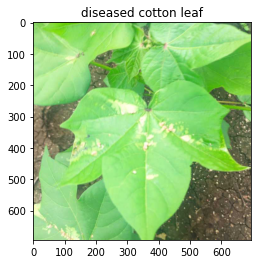

In [14]:
#plt.imshow(image.view(image.shape[1], image.shape[2], image.shape[0]))  
#change from CHW to HWC. pyplot needs HWC
plt.imshow(image.permute(1,2,0)) 
plt.title(train_classes[label])

CPU times: user 582 ms, sys: 85.1 ms, total: 667 ms
Wall time: 6.92 s


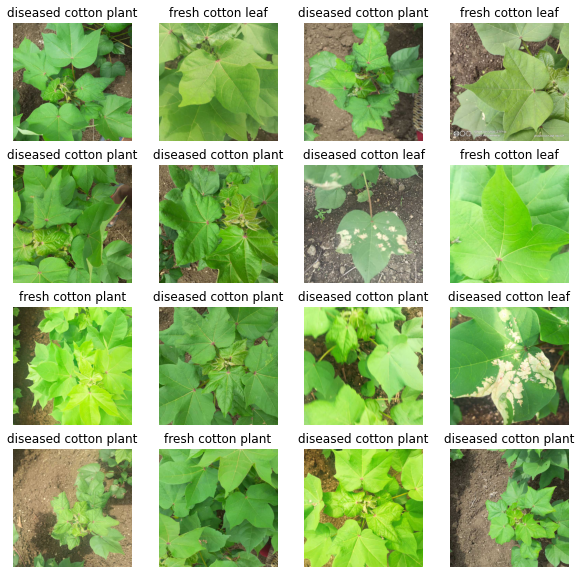

In [15]:
# Plot more images for SEEEEing them! with labels
%%time
torch.manual_seed(69)
fig = plt.figure(figsize=(10,10))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0))
    plt.title(train_classes[label])
    plt.axis(False);

#Data Loader
It helps load data into a model.

For training and for inference.

It turns a large `Dataset` into a Python iterable of smaller chunks.


In [16]:
train_data

Dataset ImageFolder
    Number of datapoints: 1951
    Root location: /content/drive/MyDrive/Crop Dataset/cotton_dataset/train
    StandardTransform
Transform: ToTensor()

In [17]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into datLoader, i.e. iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

valid_dataloader = DataLoader(valid_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=False # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=False # shuffle data every epoch?
)
len(train_dataloader), len(valid_dataloader), len(test_dataloader)

(61, 8, 4)

In [18]:
image.shape , type(image)

(torch.Size([3, 694, 694]), torch.Tensor)

#Pre-processing
normalise the H,W of each image


In [24]:
image_size =[]
for i in range(len(train_data)):
    print(i)
    img, label = train_data[i]
    image_size.append(torchvision.transforms.functional.get_image_size(img))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
image_size 
#output shows two sizes of image 694,691 and 617


Text(0.5, 1.0, '3')

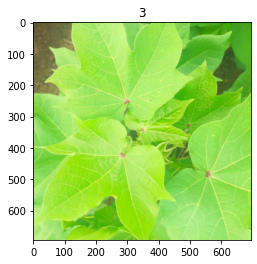

In [21]:
plt.imshow(img.permute(1,2,0)) 
plt.title(label)

In [22]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

RuntimeError: ignored

# Build base model



In [25]:
from torch import nn
class CottonDiseaseModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
#Instantiate model. 

torch.manual_seed(69)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with 

In [ ]:
# Import accuracy metric
from torchmetrics import Accuracy

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)